# Correlação

In [35]:
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import pytz
import statistics as st
import MetaTrader5 as mt5

In [36]:
pd.set_option('display.max_rows',1000)

In [37]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,8)

In [38]:
try:
    mt5.initialize()
except:    
    print("Initialize ::: Error")



    1 - GetRates retorna um DataFrame a partir de uma lista de ativos, o Periodo operacional (D1,H1,H4...) e a quantidade de barras totais


  

In [41]:
def GetRates(ativos, timeframe, BARS = 300):
    df = pd.DataFrame()
    
    # Set time
    
    time = mt5.copy_rates_from_pos(ATIVOS[0],timeframe,0,bars)   
    
    df['time'] = time['time']
    df['time'] = pd.to_datetime(df['time'], unit= 's')
    df.set_index('time', inplace = True)
    
    #set values
    
    for ativo in ativos:
        try:
            data = mt5.copy_rates_from_pos(ativo,timeframe,0,bars)
            df[ativo] = data['close']
        except:
            print("Erro:::",ativo)
    return df 

In [6]:
def highlight(var):
    return ['background-color: yellow' if i else '' for i in var] 



    2 - PlotGraphs plota um gráfico de linha e um grafico de pontos de um determinado ativo



In [40]:
def PlotGraphs(df,ativo):
    plt.subplot(1,2,1)
    plt.title(ativo)
    df[ativo[:5]].plot()
    df[ativo[6:]].plot()

    plt.subplot(1,2,2)
    plt.scatter(df[ativo[:5]], df[ativo[6:]])
    plt.show()

    3 - Regressao faz o calculo e retorna um bool do p-valor da regressão retornando True se for < 0.05 e False caso seja maior e a função também retorna um DataFrame com o resíduo

In [8]:
def Regressao(df,ativos,periodos):
    df_coef = pd.DataFrame(index=periodos,columns=ativos)
    df_pval = pd.DataFrame(index=periodos,columns = ativos)
    df_spread =  pd.DataFrame(columns = ativos)
    
    for ativo in ativos:
        for periodo in periodos:
            try:
                results = sm.OLS(df[ativo[:5]].iloc[-periodo:],df[ativo[6:]].iloc[-periodo:]).fit()
                df_pval[ativo].loc[periodo]= results.pvalues[0] <0.05
                if(periodo == periodos[-1]):
                    df_spread[ativo] = results.resid
            except:
                try:
                    results = sm.OLS(df[ativo[:6]].iloc[-periodo:],df[ativo[7:]].iloc[-periodo:]).fit()
                    df_pval[ativo].loc[periodo]= results.pvalues[0] <0.05
                    df_spread[ativo] = results.resid
                    if(periodo == periodos[-1]):
                        df_spread[ativo] =periodo
                except:
                    print("Error:::",ativo)
    return df_pval,df_spread
   

    4 - GetADF recebe o DataFrame dos resíduos, uma lista com os períodos e retorna o p-valor do teste de Adfuller 

In [9]:
def GetADF(df,periodos):

    df_adf = pd.DataFrame(index = periodos, columns=df.columns)

    for ativo in df.columns:
        for periodo in periodos:
            try:
                df_adf[ativo].loc[periodo] = adfuller(df[ativo].iloc[-periodo:], maxlag = 1)[1]
            except:
                print("Erro:::",ativo)
                
    return df_adf

    5 - PlotSpread recebe o DataFrame dos resíduos, um ativo, uma lista com a quantidade de períodos, o multiplicador do desvio padrão e plota os gráficos dos resíduos com duas barras horizontais sinalizando o limite do desvio padrão

In [31]:
def PlotSpread(df, ativo,periodos,desvio_padrao):
    i = 1
    plt.figure(figsize=(20, 20))
    for periodo in periodos:
        plt.subplot(3,int(len(periodos)/3)+1,i)
        plt.title(str(periodo))
        lim = max(df[ativo].iloc[-periodo:].values.max(),abs(df[ativo].iloc[-periodo:].values.min()))
        df[ativo].iloc[-periodo:].plot().set_ylim([1.2*lim,-1.2*lim])
        
        desvio = st.stdev(df[ativo].iloc[-periodo:])
        plt.axhline(y=desvio_padrao*desvio, color='r', linestyle='-')
        plt.axhline(y=-desvio_padrao*desvio, color='r', linestyle='-')
        plt.axhline(y=0, color='g', linestyle='-')
        plt.xlabel("")
        i +=1
       
    plt.show()

In [11]:
periodos = [100,120,140,160,180,200,250]

In [12]:
indice = ["B3SA3","ITUB4","PETR4","BBDC4","PETR3","ABEV3","MGLU3","WEGE3","BBAS3","ITSA4","JBSS3","SUZB3","VALE3",
          "NTCO3","LREN3","GNDI3","RENT3","LAME4","VVAR3","BBDC3","EQTL3","RAIL3","RADL3","BTOW3","VIVT4","UGPA3",
          "BPAC11","GGBR4","SBSP3","BBSE3","BRFS3","KLBN11","BRDT3","CCRO3","HAPV3","HYPE3","SULA11","COGN3","CSAN3",
          "TIMP3","ELET3","ENGI11","EGIE3","TOTS3","SANB11","CMIG4","PCAR3","BRAP4","IRBR3","YDUQ3","CSNA3","BRML3",
          "ELET6","QUAL3","CRFB3","FLRY3","MRFG3","AZUL4","CYRE3","BRKM5","AEE11","MULT3","GOAU4","EMBR3","CIEL3",
          "MRVE3","ENBR3","CPFE3","USIM5","BEEF3","CVCB3","IGTA3","GOLL4","ECOR3","HGTX3"]

len(indice)

75

In [14]:
try:
    df_indice = GetRates(indice,mt5.TIMEFRAME_D1,300)

except:
    url = "https://raw.githubusercontent.com/tomas-lucena/csv_indice_daily/master/indice_daily.csv"
    df_indice = pd.read_csv(url,sep =";", index_col=0)

In [15]:
# df_indice.to_csv("indice_daily.csv", encoding='utf-8',sep=';')

In [27]:
lista_ativos =[]

num = len(df_indice.columns)   # número de ativos

for ativo in df_indice.iloc[:,:num]:
    for aux in df_indice.iloc[:,:num]:
        if(ativo != aux):
            lista_ativos.append(ativo+ "_"+ aux)

len(lista_ativos) # número de combinações totais

5256

In [17]:
df_pval, df_spread = Regressao(df_indice, lista_ativos, periodos)

# df_pval.T.head()       p-Value
# df_spread.head()       residue

np.seterr(invalid='ignore')
df_adf_values = GetADF(df_spread, periodos).T

df_adf_bool = (df_adf_values > 0.95)

# df_adf_values.head()   p-Value ADF
# df_adf_bool.head()     p-Value > 0.95

df_ADF = df_adf_bool[df_adf_bool.apply(lambda row : row.astype(str).str.contains("True").any(),axis =1)]

df_ADF = df_ADF.style.apply(highlight)

c:\users\tomas lucena\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [18]:
for ativo in lista_ativos[:1]:
    pass # PlotGraphs(df,ativo)

In [19]:
# PlotGraphs(df,"PETR4_WEGE3")

In [44]:
df_ADF # DataFrame dos ativos que tem pelo menos um dos períodos com p-Valor > 0.95

,100,120,140,160,180,200,250
B3SA3_ITUB4,False,False,False,False,True,True,True
B3SA3_BBDC4,False,False,False,False,True,True,True
B3SA3_ABEV3,False,False,False,False,False,True,True
B3SA3_BBAS3,False,False,False,False,True,True,True
B3SA3_ITSA4,False,False,False,False,True,True,True
B3SA3_LREN3,False,False,False,False,True,True,True
B3SA3_BBDC3,False,False,False,False,True,True,True
B3SA3_BBSE3,False,False,False,False,True,True,True
B3SA3_CCRO3,False,False,False,False,True,True,True
B3SA3_ENGI11,True,False,False,False,True,True,True


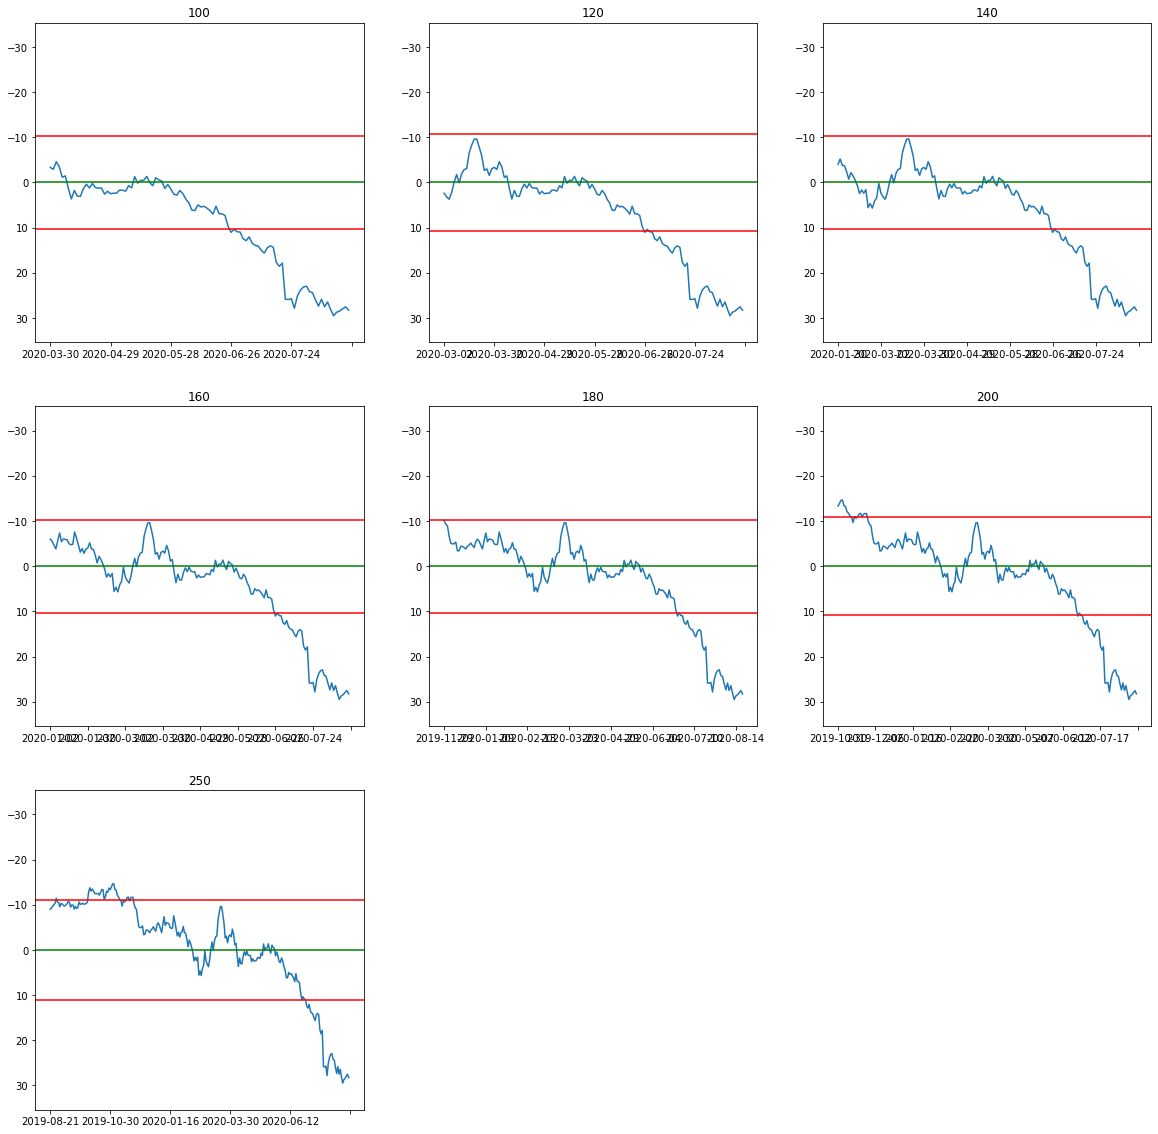

In [45]:
PlotSpread(df_spread,'WEGE3_RADL3',periodos,1)